In [1]:
from aicsimageio import AICSImage
import numpy as np

scenes = np.arange(0,70,4)  # Scenes to be imported
a = a.tolist()
timepoint = 3    # t=3 (12h)
cziFile = AICSImage("D:/LSM/2021-06-10/New-01.czi")

# cziFile.dask_data
# cziFile.xarray_dask_data
cziArr = []
for i in a:
#     #print(len(imgArr))
    cziFile.set_scene(int(i)) 
    lazyCurrentScene = cziFile.get_image_dask_data("CYX", T=timepoint)   # Stepwise loading of the image (lazy load)
    currentScene = lazyCurrentScene.compute()    # Execute the loading
    maskedArr = np.ma.array(currentScene)
    cziArr.append(maskedArr)
#     #print(len(imgArr))


del cziFile, currentScene, lazyCurrentScene
# with AICSImage("D:/LSM/2021-06-10/New-01.czi") as cziFile:
#     for i in a:
#         cziFile.set_scene(int(i))
#         cziArr.append(cziFile.get_image_data("TCYX"))

107.5094735622406


In [2]:
## Applying masks to the images

from skimage import exposure
from skimage.filters import threshold_li
import skimage.morphology as skmorp
from scipy import ndimage as ndi
from copy import copy
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 16})

# start = time.time()

# fig, ax = plt.subplots(len(cziArr), 6, figsize=(35,90), subplot_kw={'xticks': [], 'yticks': []})

## Colour map ##
# grayCmap = copy(plt.cm.gray)
# grayCmap.set_bad('k')

for i in range(len(cziArr)):
    cziArr[i].mask = np.ma.nomask   # Reset the masks to no mask
    sumImage = np.sum(cziArr[i],axis=0) # Sum of all slices
    sumImage.mask = np.ma.nomask
    # ax[i,0].imshow(sumImage, cmap='gray')
    # ax[i,0].set_ylabel(('# '+str(i+1)), labelpad=20,rotation='horizontal')
    
    ## Contrast enhancement ##
    p2, p98 = np.percentile(sumImage, (2,98)) # 2nd and 98th percentiles of the current image intensities
    imgRescaled = exposure.rescale_intensity(sumImage, in_range=(p2,p98), out_range='dtype') # Rescale the intensities by stretching the histogram using the intensities between 2-98 percentiles
    imgRescaled = np.ma.array(imgRescaled)
    
    # ax[i,1].imshow(imgRescaled, cmap='gray')
    #not used# imgRescaled = ndi.gaussian_filter(imgRescaled, sigma=1)
    ## Thresholding ##
    thresh = threshold_li(imgRescaled)
    binary = imgRescaled>thresh     # True = The pixels to be used, False = pixels to be masked out (Background)
    # ax[i,2].imshow(binary, interpolation='none', cmap='gray')
    
    ## Binary open ##
    binary2 = skmorp.binary_opening(binary)
    binary2 = skmorp.binary_dilation(binary2)
    # ax[i,3].imshow(binary2, interpolation='none', cmap='gray')
    
    ## Fill holes ##
    binary3 = ndi.binary_fill_holes(binary2)
    binary3 = skmorp.binary_dilation(binary3)
    # ax[i,4].imshow(binary3, interpolation='none', cmap='gray')
    
    ## Apply the mask to the current image stack ##
    invertedMask = np.invert(binary3)  # True => Pixel will be masked, False => Pixel will be shown/used
    cziArr[i].mask = invertedMask
    # imgRescaled.mask = invertedMask  # For showing the masked sum image
    # sumMaskedImage = np.sum(cziArr[i],axis=0)  # Not used # For showing the masked image
    # ax[i,5].imshow(imgRescaled, cmap=grayCmap)

# ax[0,0].set_title('Sum of the slices')
# ax[0,1].set_title('Contrast adjusted sum')
# ax[0,2].set_title('Li thresholding binary mask')
# ax[0,3].set_title('Binary opening + dilation')
# ax[0,4].set_title('Fill holes + dilation')
# ax[0,5].set_title('Mask applied to the sum image')
# fig.tight_layout()
# end = time.time()
# plt.show()

# print(end - start)


In [3]:
## Converting the image array to a python list in which each element is an image array (np array)

scenes = np.arange(len(cziArr),dtype=object) #Create an array of class names (experiment groups) corresponding to each scene
scenes[:6] = 'control'
scenes[6:10] = 'diclo1x'
scenes[10:13] = 'doxo05x'
scenes[13:] = 'doxo025x'
scenes = scenes.tolist()
imgArray = []
classList = []
shape = cziArr[0].shape
# imgArray becomes a python list with number of elements equal to the number of scenes. Each element is a (dim(y)*dim(x), 33) sized array (corresponds to 1 lambda stack)
# from the time point given by the variable 'timepoint'
for j in range(len(cziArr)):  
    imgArray.append(cziArr[j].reshape(shape[0],(shape[1]*shape[2])).T)
    #classArray = np.full((imgArray[j].shape[0],1), scenes[j])
    #imgArray[j] = np.append(imgArray[j],classArray,axis=1)
    classList += imgArray[j].shape[0] * [scenes[j]]
# classList = np.array(classList).reshape(-1,1)    

# del i, j, cziArr

#imgArr[0][3].shape # 0: 1st scene (well B02), 3: t=3

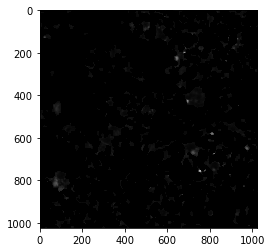

In [6]:
## Show an image to check if the images are stored in the array correctly and if they can be restored:


import matplotlib.pyplot as plt
grayCmap = copy(plt.cm.gray)
grayCmap.set_bad('k')
sumA = np.sum(imgArray[0],axis=1)
imgReconstr = sumA.reshape(1024,1024)
imgplot = plt.imshow(imgReconstr, cmap=grayCmap)
plt.show()



In [4]:
## Import the image arrays as a Pandas DataFrame

import pandas as pd
columns = 33 * ['ch']
chNumbers = np.array(np.arange(1,34), dtype='<U8')
for i in range(len(columns)):
    chNumbers[i] = columns[i]+chNumbers[i]
chNumbers = chNumbers.tolist()
df = pd.DataFrame(imgArray[0], columns=chNumbers)
currentScene = []
for i in range(1,len(imgArray)):
    currentScene = pd.DataFrame(imgArray[i], columns=chNumbers)
    df = df.append(currentScene, ignore_index=True)
df['class'] = classList
df.head(5)


,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,...,ch25,ch26,ch27,ch28,ch29,ch30,ch31,ch32,ch33,class
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control


In [5]:
## Remove rows containing NaN values (masked pixels)

df = df.dropna()
df.head(5)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,...,ch25,ch26,ch27,ch28,ch29,ch30,ch31,ch32,ch33,class
8,212.0,138.0,80.0,181.0,97.0,129.0,76.0,147.0,97.0,230.0,...,59.0,96.0,234.0,27.0,144.0,146.0,13.0,22.0,11.0,control
9,174.0,140.0,118.0,145.0,279.0,200.0,163.0,59.0,28.0,233.0,...,102.0,130.0,225.0,32.0,83.0,133.0,3.0,10.0,12.0,control
10,185.0,112.0,42.0,111.0,104.0,90.0,111.0,157.0,11.0,204.0,...,107.0,107.0,263.0,12.0,94.0,137.0,10.0,8.0,13.0,control
52,209.0,143.0,187.0,147.0,78.0,103.0,41.0,74.0,97.0,277.0,...,101.0,72.0,163.0,9.0,125.0,195.0,23.0,15.0,18.0,control
53,181.0,180.0,104.0,162.0,154.0,116.0,59.0,13.0,2.0,168.0,...,85.0,84.0,172.0,19.0,117.0,134.0,12.0,25.0,16.0,control


In [6]:
## Convert the datatypes from float to integer (in case of masking)

df = df.astype({'ch1':'int32','ch2':'int32','ch3':'int32','ch4':'int32','ch5':'int32','ch6':'int32','ch7':'int32','ch8':'int32',
               'ch9':'int32','ch10':'int32','ch11':'int32','ch12':'int32','ch13':'int32','ch14':'int32','ch15':'int32','ch16':'int32',
               'ch17':'int32','ch18':'int32','ch19':'int32','ch20':'int32','ch21':'int32','ch22':'int32','ch23':'int32','ch24':'int32',
               'ch25':'int32','ch26':'int32','ch27':'int32','ch28':'int32','ch29':'int32','ch30':'int32','ch31':'int32','ch32':'int32','ch33':'int32'})
df.head(5)


,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,...,ch25,ch26,ch27,ch28,ch29,ch30,ch31,ch32,ch33,class
8,212,138,80,181,97,129,76,147,97,230,...,59,96,234,27,144,146,13,22,11,control
9,174,140,118,145,279,200,163,59,28,233,...,102,130,225,32,83,133,3,10,12,control
10,185,112,42,111,104,90,111,157,11,204,...,107,107,263,12,94,137,10,8,13,control
52,209,143,187,147,78,103,41,74,97,277,...,101,72,163,9,125,195,23,15,18,control
53,181,180,104,162,154,116,59,13,2,168,...,85,84,172,19,117,134,12,25,16,control


In [7]:
## Creating the intensity matrix and class label vector

X = df.iloc[:,0:33].values  ## X: The matrix that contains the intensity values of each pixel in lambda channels (2 columns * no.of pixels)
y = df.iloc[:,33].values  ## y: Vector containing the class labels (= experiment group names) (1 column * no.of pixels)


In [8]:
np.save('new01t3_valueArray_X.npy',X)
np.save('new01t3_labelArray_y.npy',y)

In [ ]:
## Show histogram for each channel (Distribution of intensity data for each spectral channel)

from matplotlib import pyplot as plt
import numpy as np
import math
plt.rcParams.update({'font.size': 13})

label_dict = {1: 'control', 2: 'diclo1x', 3: 'doxo025x', 4: 'doxo05x'}
feature_dict = {0:'Ch1', 1:'Ch2', 2:'Ch3', 3:'Ch4', 4:'Ch5', 5:'Ch6', 6:'Ch7', 7:'Ch8', 8:'Ch9', 9:'Ch10', 10:'Ch11', 11:'Ch12', 12:'Ch13', 
                13:'Ch14', 14:'Ch15', 15:'Ch16', 16:'Ch17', 17:'Ch18', 18:'Ch19', 19:'Ch20', 20:'Ch21', 21:'Ch22', 22:'Ch23', 23:'Ch24', 
                24:'Ch25', 25:'Ch26', 26:'Ch27', 27:'Ch28', 28:'Ch29', 29:'Ch30', 30:'Ch31', 31:'Ch32', 32:'Ch33'}
with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure(figsize=(40,10))
    for i in range(33):
        fig.add_subplot(3,12,i+1)
        for lab in ('control','diclo1x','doxo025x','doxo05x'):
            plt.hist(X[y==lab, i], label=lab, bins=32, alpha=0.3, log=True)
        plt.xlabel(feature_dict[i])
    plt.legend(loc='upper right', fancybox=True)
    plt.tight_layout()
    plt.show()
        
        # plt.subplots(6,6,figsize=(20,12))

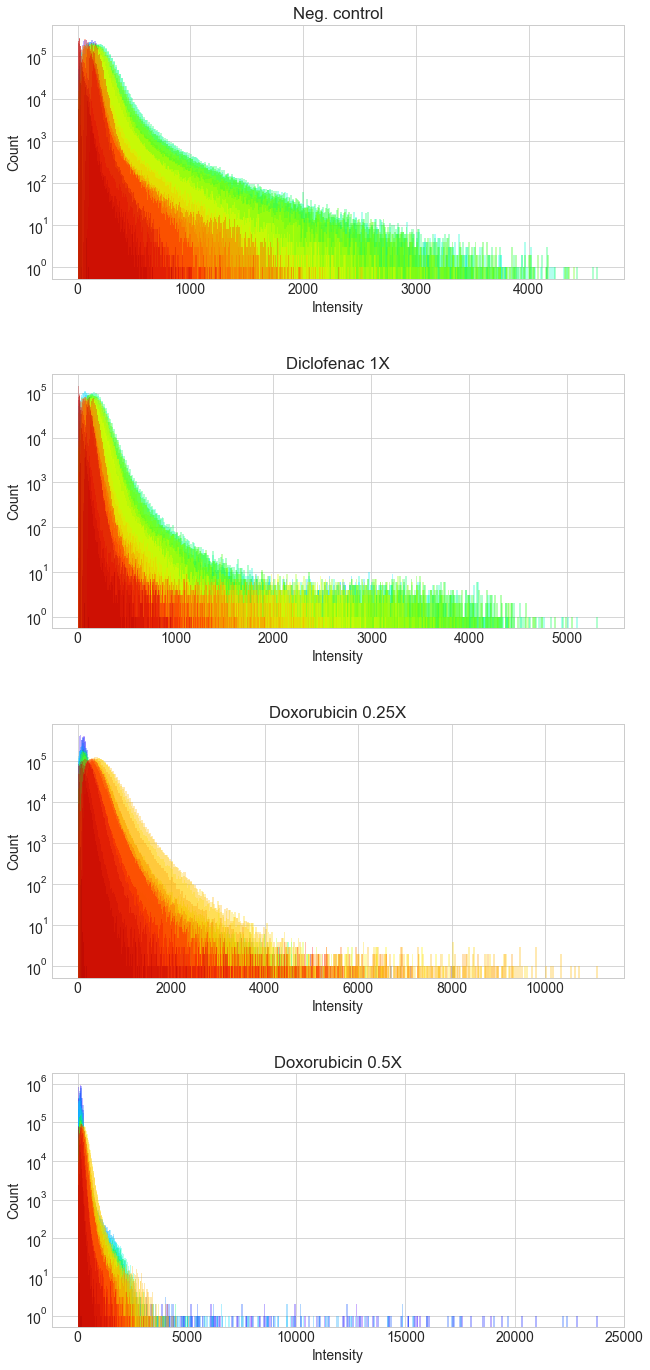

In [110]:
## Colour histogram for each experimental group

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
feature_dict = {0:'Ch1', 1:'Ch2', 2:'Ch3', 3:'Ch4', 4:'Ch5', 5:'Ch6', 6:'Ch7', 7:'Ch8', 8:'Ch9', 9:'Ch10', 10:'Ch11', 11:'Ch12', 12:'Ch13', 
                13:'Ch14', 14:'Ch15', 15:'Ch16', 16:'Ch17', 17:'Ch18', 18:'Ch19', 19:'Ch20', 20:'Ch21', 21:'Ch22', 22:'Ch23', 23:'Ch24', 
                24:'Ch25', 25:'Ch26', 26:'Ch27', 27:'Ch28', 28:'Ch29', 29:'Ch30', 30:'Ch31', 31:'Ch32', 32:'Ch33'}
label = ['Neg. control','Diclofenac 1X', 'Doxorubicin 0.25X','Doxorubicin 0.5X']
col = ['#7500EE', '#5700FF', '#2D00FF', '#0012FF', '#004AFF', '#0078FF', '#00A2FF', '#00CAFF', '#00EFFF', '#00FFC9', '#00FF61', '#13FF00', 
'#3CFF00', '#5FFF00', '#7FFF00', '#9DFF00', '#B9FF00', '#D5FF00', '#EFFF00', '#FFF300', '#FFD600', '#FFB900', '#FF9A00', '#FF7900', '#FF5600', 
'#FF3000', '#FF0000', '#EE0101', '#D91414', '#CB0000', '#C10606', '#B70202', '#A40000']
with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure(figsize=(10,20))
    for i, lab in zip(range(4),('control','diclo1x','doxo025x','doxo05x')):
        ax = fig.add_subplot(4,1,i+1)
        for j in range(df.shape[1]-1):
            plt.hist(X[y==lab, j], label=feature_dict[j], color=col[j], bins=256, alpha=0.3, log=True)
        ax.set_title(label[i])
        ax.set_xlabel('Intensity')
        ax.set_ylabel('Count')
    fig.tight_layout(pad=3)
    #ax.legend()
    #ax.set_xticks([0,20000])
    plt.show()

In [10]:
## Standardizing the data
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

### To skip standardization:
# X_std = X

### Distribution of the data after standardization

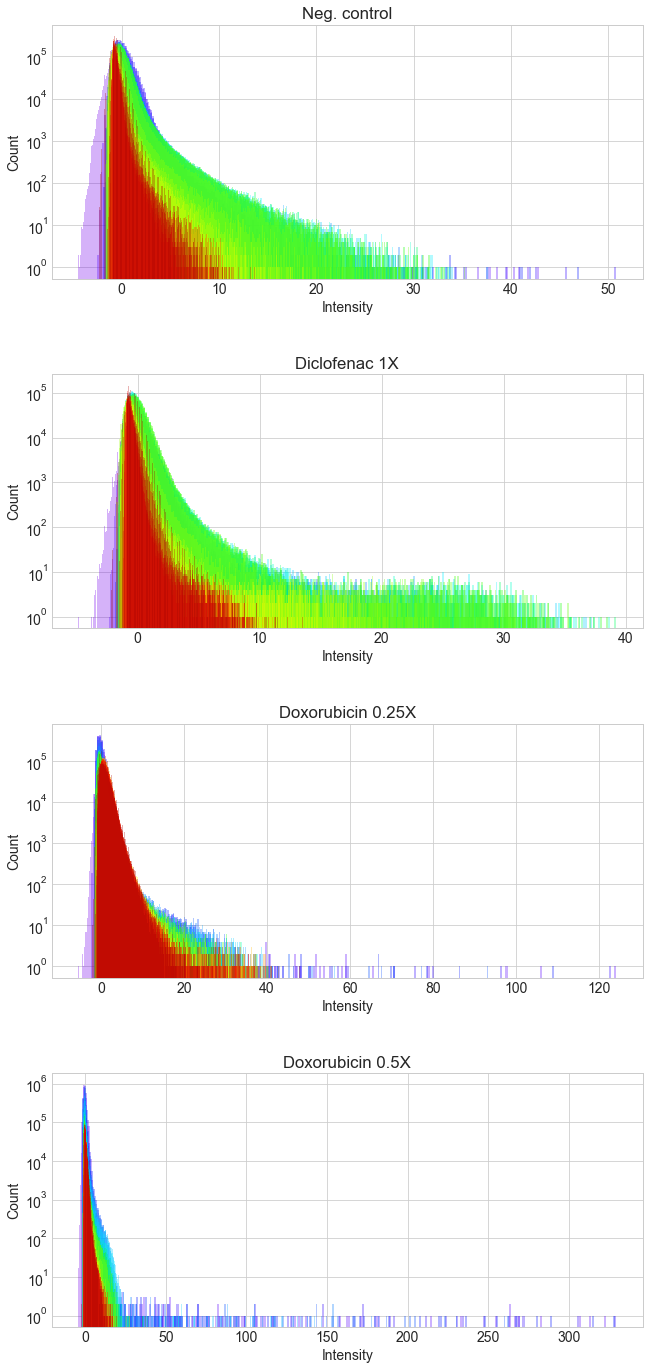

In [112]:
with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure(figsize=(10,20))
    for i, lab in zip(range(4),('control','diclo1x','doxo025x','doxo05x')):
        ax = fig.add_subplot(4,1,i+1)
        for j in range(X.shape[1]):
            plt.hist(X_std[y==lab, j], label=feature_dict[j], color=col[j], bins=256, alpha=0.3, log=True)
        ax.set_title(label[i])
        ax.set_xlabel('Intensity')
        ax.set_ylabel('Count')
    fig.tight_layout(pad=3)
    plt.show()

# Covariance matrix

In [15]:

# mean_vec_std = np.mean(X_std, axis=0)   # With standardization
# cov_mat_std = (X_std - mean_vec_std).T.dot((X_std - mean_vec_std)) / (X_std.shape[0]-1)
cov_mat_std = (X_std.T @ X_std) / (X_std.shape[0]-1)

print('Covariance matrix (Standardized data)\n%s\n' %cov_mat_std)

# mean_vec = np.mean(X, axis=0)   # Without standardization
# cov_mat = (X - mean_vec).T.dot((X - mean_vec)) / (X.shape[0]-1)
# print('Covariance matrix (No standardization)\n%s\n' %cov_mat)

Covariance matrix (Standardized data)
[[1.00000015 0.18370563 0.13063334 ... 0.13402    0.1284534  0.17139019]
 [0.18370563 1.00000015 0.40818253 ... 0.02731052 0.03129584 0.03614472]
 [0.13063334 0.40818253 1.00000015 ... 0.07502594 0.07991343 0.07221799]
 ...
 [0.13402    0.02731052 0.07502594 ... 1.00000015 0.60783196 0.55698886]
 [0.1284534  0.03129584 0.07991343 ... 0.60783196 1.00000015 0.51567998]
 [0.17139019 0.03614472 0.07221799 ... 0.55698886 0.51567998 1.00000015]]



In [ ]:
import dask.array as da
import dask

u, s, v = da.linalg.svd(X_std.T)
dask.visualize(u, s, v)


**Only standardized data is used for the next steps**
# Eigenvectors, eigenvalues


In [16]:
# eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_vals_std, eig_vecs_std = np.linalg.eig(cov_mat_std)

print('Standardized data \n ---------------------')
print('Eigenvectors \n%s' %eig_vecs_std)
print('\nEigenvalues \n%s\n' %eig_vals_std)
# print('Without standardization \n ---------------------')
# print('Eigenvectors \n%s' %eig_vecs)
# print('\nEigenvalues \n%s\n' %eig_vals)

Standardized data 
 ---------------------
Eigenvectors 
[[-3.97682468e-02  1.20135655e-02  5.03900225e-01 ...  1.25704910e-02
   2.56306688e-02  5.23855741e-03]
 [-3.93237666e-02 -1.51121087e-01  5.19739781e-01 ... -2.45090592e-03
   2.72353951e-03 -5.55200590e-03]
 [-6.52552669e-02 -1.83073393e-01  4.07187145e-01 ...  4.27928122e-03
   1.12994457e-02 -4.85117584e-04]
 ...
 [-1.98823940e-01  9.89717122e-02  2.80571637e-02 ...  1.17939763e-01
   1.61899591e-01  2.67758335e-02]
 [-1.85931797e-01  8.78205450e-02  3.32340129e-02 ...  5.28905639e-03
  -2.99395277e-02 -9.45873000e-03]
 [-1.74181636e-01  8.64930003e-02  7.35746944e-02 ...  1.33451606e-02
  -1.26195396e-02 -6.26391128e-03]]

Eigenvalues 
[14.80053493  7.07333683  1.41959634  0.84300129  0.59944751  0.55145574
  0.5108831   0.48050905  0.45644142  0.42712316  0.10907956  0.12153501
  0.13868056  0.15402628  0.16549185  0.38676321  0.37432543  0.18010827
  0.19048383  0.20318467  0.21141266  0.22267864  0.24214058  0.25483785
  

In [14]:
# pc1 = pd.Series(eig_vecs_std[:,0])
# pc2 = pd.Series(eig_vecs_std[:,1])

dfPCs = pd.DataFrame(eig_vecs_std[:,0:2], columns=['PC1', 'PC2'])
dfPCs

,PC1,PC2
0,-0.005003,-0.001915
1,-0.004863,0.052104
2,-0.013176,0.081587
3,-0.021291,0.125352
4,-0.031498,0.172016
5,-0.036940,0.217484
6,-0.046747,0.255144
7,-0.047936,0.264444
8,-0.052548,0.283939
9,-0.054096,0.323769


## Sorting eigenvalues

In [17]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs_std = [(np.abs(eig_vals_std[i]), eig_vecs_std[:,i]) for i in range(len(eig_vals_std))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs_std.sort(key=lambda x: x[0], reverse=True)
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order: ')
for i in eig_pairs_std:
    print(i[0])
    
# eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
# eig_pairs.sort(key=lambda x: x[0], reverse=True)
# print('Eigenvalues in descending order: (not standardized)')
# for i in eig_pairs:
#     print(i[0])

Eigenvalues in descending order: 
14.800534927041712
7.073336828840971
1.4195963414264758
0.8430012918470708
0.5994475118675946
0.5514557437124387
0.5108831026473043
0.48050904572039993
0.4564414233991922
0.427123163451933
0.3867632068719748
0.37432543204549995
0.36030124641822625
0.3486216643559848
0.33634116233294453
0.32687048144570124
0.3166187880835524
0.31238183694767513
0.2999193724237475
0.2982743916888159
0.2835983392323393
0.25483784724802816
0.24214058331929086
0.22267863829750945
0.2114126553677682
0.2031846747519693
0.19048382500051908
0.18010826532557983
0.16549184732958683
0.1540262785799392
0.13868055822718145
0.12153500902123589
0.10907955802323988


In [18]:
eig_vals_std

array([14.80053493,  7.07333683,  1.41959634,  0.84300129,  0.59944751,
        0.55145574,  0.5108831 ,  0.48050905,  0.45644142,  0.42712316,
        0.10907956,  0.12153501,  0.13868056,  0.15402628,  0.16549185,
        0.38676321,  0.37432543,  0.18010827,  0.19048383,  0.20318467,
        0.21141266,  0.22267864,  0.24214058,  0.25483785,  0.36030125,
        0.34862166,  0.33634116,  0.28359834,  0.32687048,  0.31661879,
        0.31238184,  0.29991937,  0.29827439])

# Explained variance

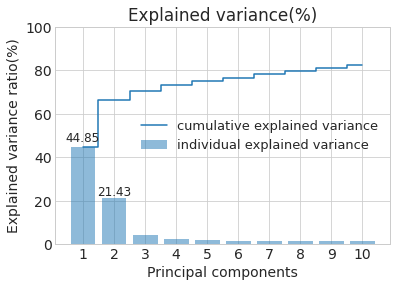

In [19]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

tot_std = sum(eig_vals_std)
var_exp_std = [(i / tot_std)*100 for i in sorted(eig_vals_std, reverse=True)]
cum_var_exp_std = np.cumsum(var_exp_std)

with plt.style.context('seaborn-whitegrid'):
    fig,ax1 = plt.subplots()
    barPlot = ax1.bar(range(10), var_exp_std[:10], alpha=0.5, align='center', label='individual explained variance')
    ax1.step(range(10), cum_var_exp_std[:10], where='mid', label='cumulative explained variance')
    ax1.set_title('Explained variance(%)')
    ax1.set_ylabel('Explained variance ratio(%)')
    ax1.set_xlabel('Principal components')
    ax1.set_xticks(np.arange(0,10,1)), ax1.set_xticklabels(np.arange(1,11,1))
    ax1.set_ylim(0,100)
    ax1.legend(loc='right', fontsize=13)
    ## Show the values on the bars with variance greater than or equal to 10%:
    labelBar = barPlot.datavalues[barPlot.datavalues>=10]
    for i in range(len(labelBar)):
        ax1.text(ax1.patches[i].get_x()+ax1.patches[i].get_width()/2 ,labelBar[i]*1.05,"{:.2f}".format(labelBar[i]), ha="center",size=12)
        


In [13]:
ax1.patches[0]

In [17]:
var_exp_std

[63.10020318472643,
 15.366037666969984,
 1.4940537726876157,
 1.200224441046816,
 1.1796407085003562,
 1.1454668541592778,
 1.0760975198706901,
 1.041944867320713,
 1.0186456086019111,
 0.9518950128631822,
 0.9120375602901208,
 0.8817374718462735,
 0.8495681938192039,
 0.7913994773489579,
 0.7784076224118363,
 0.7580223503840042,
 0.7422039376065017,
 0.6700297733461086,
 0.6546222151766815,
 0.6209374902448,
 0.6123911533945665,
 0.5643682130014572,
 0.5359292358653596,
 0.5353501050890372,
 0.4647289968150909,
 0.4474641153241213,
 0.4002731475515963,
 0.33330774196543667,
 0.3021332624899633,
 0.24659855875862682,
 0.24133525484416815,
 0.07851635893218331,
 0.004428126746917278]

# Projection Onto the New Feature Space

In [20]:
# Projection matrix
matrix_w_std = np.hstack((eig_pairs_std[0][1].reshape(33,1),eig_pairs_std[1][1].reshape(33,1)))
print('Projection Matrix W: (Standardized data)\n', matrix_w_std)

Projection Matrix W: (Standardized data)
 [[-0.03976825  0.01201357]
 [-0.03932377 -0.15112109]
 [-0.06525527 -0.18307339]
 [-0.08015786 -0.21340272]
 [-0.09589621 -0.23677845]
 [-0.10078563 -0.25731497]
 [-0.10989832 -0.26255149]
 [-0.11119979 -0.26662692]
 [-0.11454389 -0.26842785]
 [-0.10878959 -0.27184453]
 [-0.10769436 -0.2697017 ]
 [-0.10679435 -0.26598574]
 [-0.10831522 -0.25664488]
 [-0.11921379 -0.24348219]
 [-0.1629836  -0.17939221]
 [-0.20986914 -0.06699324]
 [-0.22651609  0.00340495]
 [-0.22831514  0.03650111]
 [-0.22992483  0.05528099]
 [-0.23153211  0.08643566]
 [-0.23040549  0.1144292 ]
 [-0.22700427  0.12864251]
 [-0.22527725  0.12838859]
 [-0.22423469  0.12053891]
 [-0.22381822  0.11651667]
 [-0.22028522  0.11823367]
 [-0.2174334   0.12595652]
 [-0.21396017  0.12877421]
 [-0.20996407  0.12322438]
 [-0.20523065  0.10816429]
 [-0.19882394  0.09897171]
 [-0.1859318   0.08782054]
 [-0.17418164  0.086493  ]]


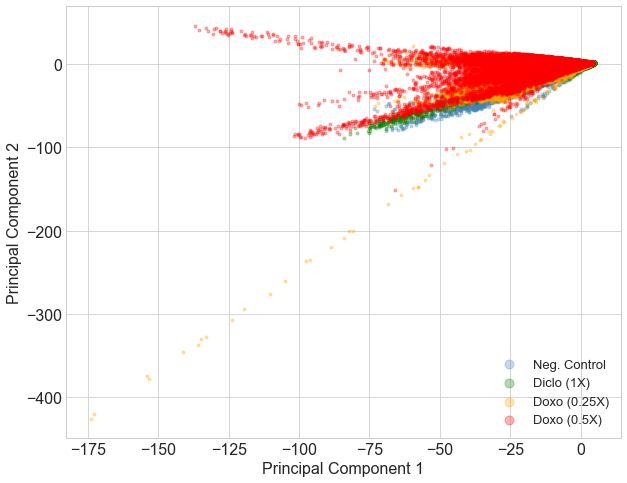

In [21]:
# Projection
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

Y_std = X_std.dot(matrix_w_std)

with plt.style.context('seaborn-whitegrid'): 
    fig,ax = plt.subplots(figsize=(9,7))
    for lab, col in zip(('control', 'diclo1x', 'doxo025x', 'doxo05x'),
                        ('steelblue', 'green', 'orange','red')):
        ax.scatter(Y_std[y==lab, 0], Y_std[y==lab, 1], label=lab, c=col, marker=".", alpha=0.3)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend(['Neg. Control','Diclo (1X)','Doxo (0.25X)','Doxo (0.5X)'],loc='lower right', fancybox=True, fontsize=13, markerscale=3)
    fig.tight_layout()
    plt.show()

In [22]:
# Create a DataFrame from the projected data for plotting

dfY = pd.DataFrame(Y_std, columns=['pc1','pc2'])
dfY['class'] = y


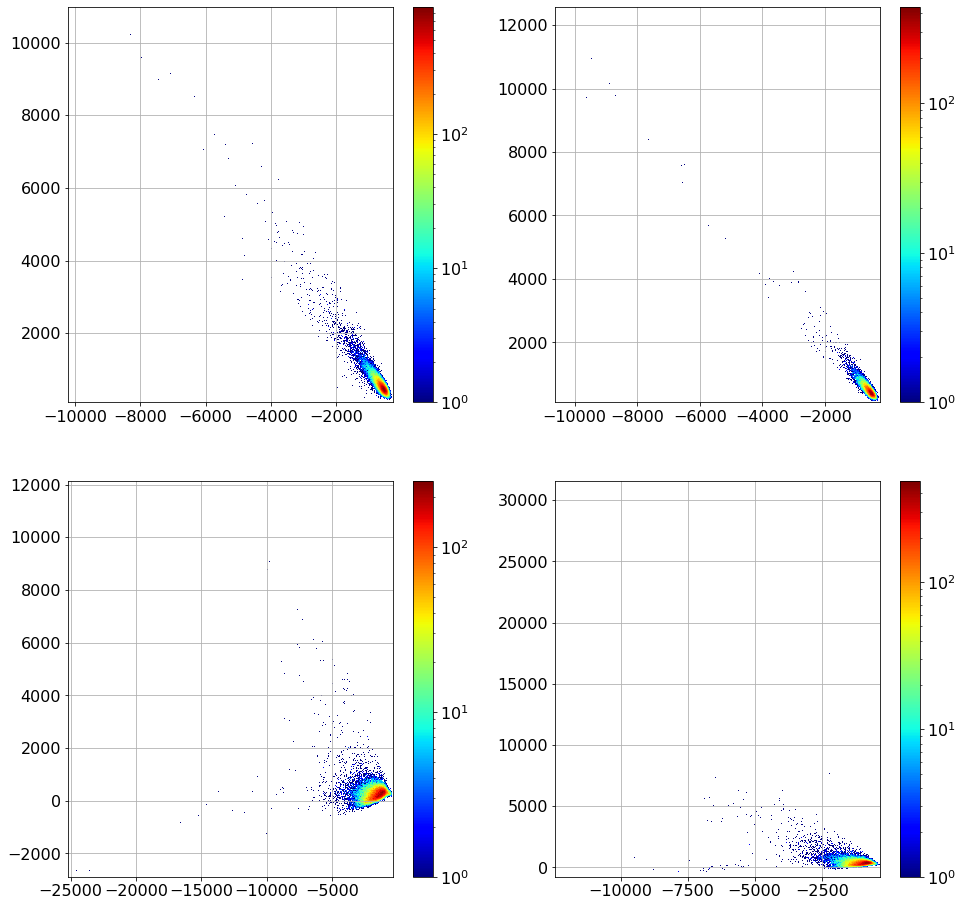

In [17]:
# import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib import colors
# plot = sns.FacetGrid(dfY, col="class", col_wrap=2, height=8)
# plot.map(sns.histplot, "pc1", "pc2", bins=128, cbar=True, norm=LogNorm())

fig = plt.figure(figsize = (16,16))
for i, lab, col in zip(range(4),('control', 'diclo1x', 'doxo025x', 'doxo05x'), ('jet', 'jet', 'jet','jet')):
    ax = fig.add_subplot(2,2,i+1)
    nBins = int(np.floor(np.sqrt(len(Y_std))))
    plot = ax.hist2d(Y_std[y==lab,0], Y_std[y==lab,1], bins = nBins, cmap=col, norm = colors.LogNorm())
    # ax.set_xlim(-20,275),ax.set_xticks([0,50,100,150,200,250])
    # ax.set_ylim(-100,550),ax.set_yticks([-100,0,100,200,300,400,500])
    fig.colorbar(plot[3], ax=ax), ax.grid(True)
plt.show()

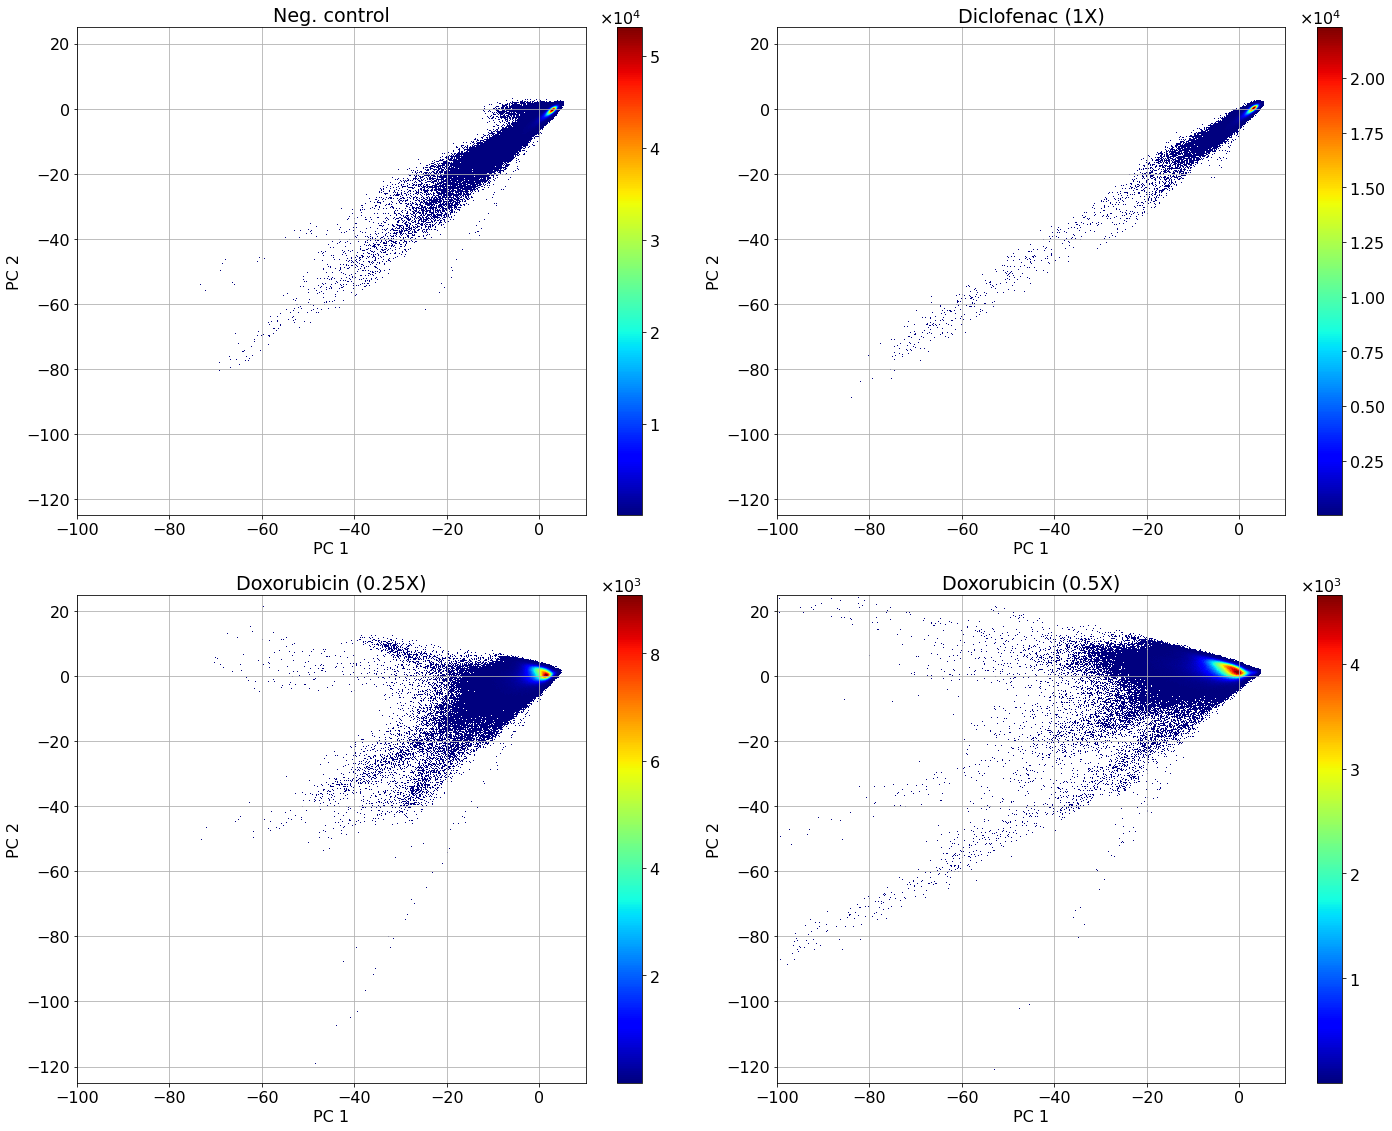

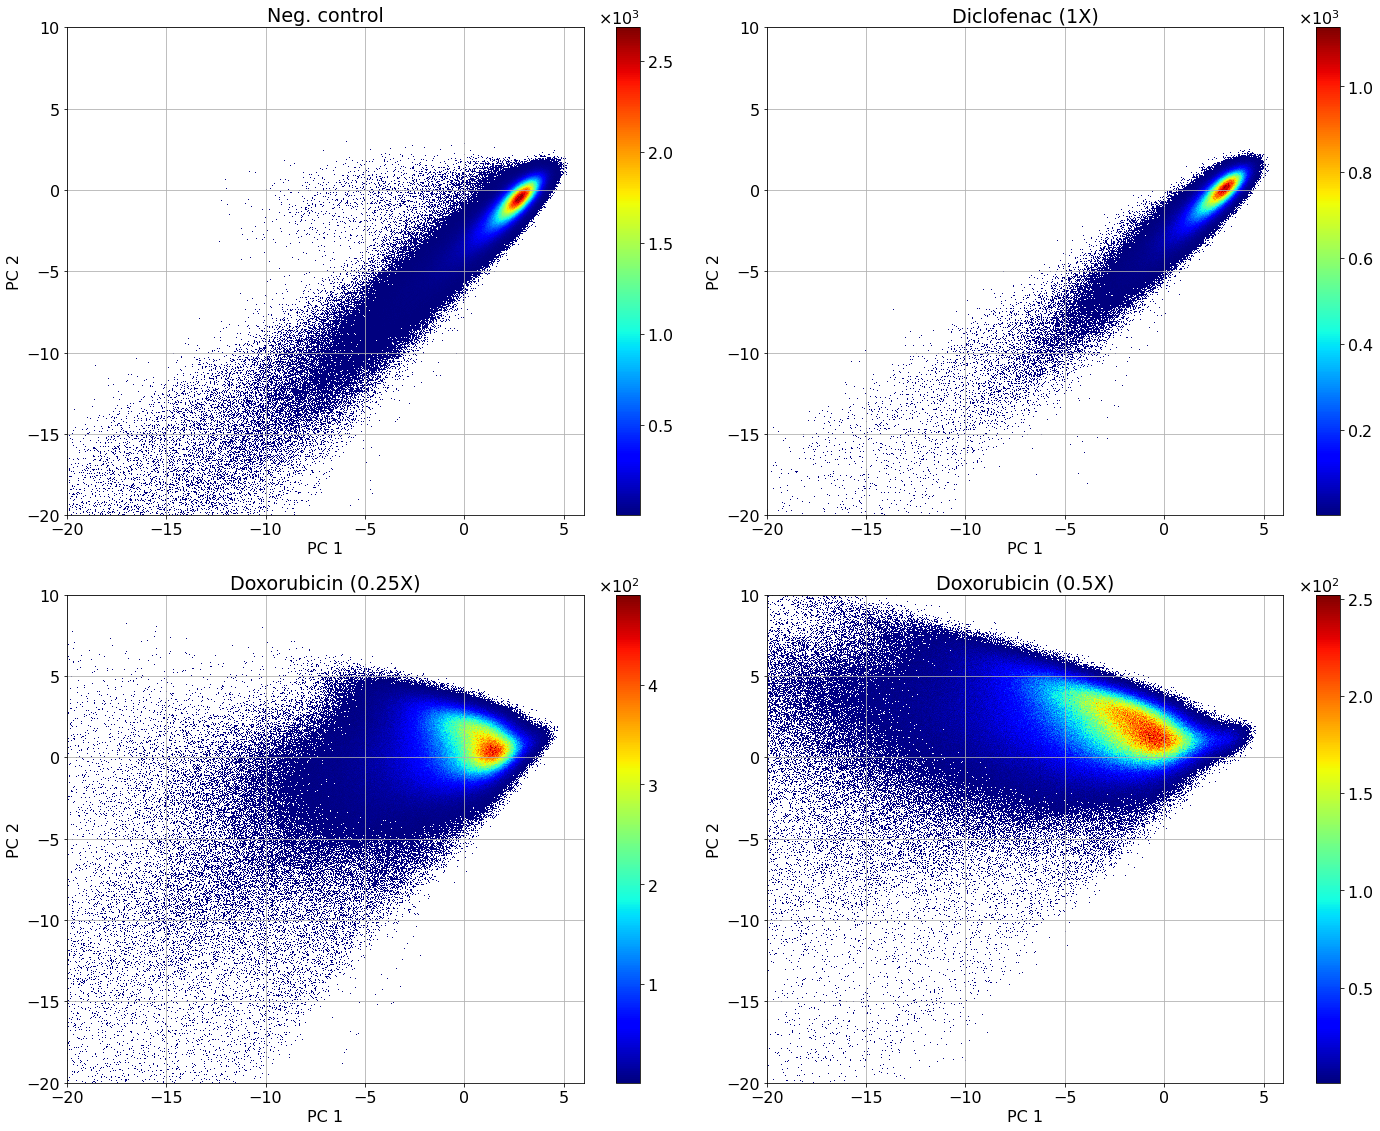

In [26]:
# import mpl_scatter_density
import datashader as ds
from datashader.mpl_ext import dsshow
# from matplotlib.colors import LogNorm
from matplotlib import colors
from matplotlib import ticker
# from matplotlib.colors import LinearSegmentedColormap

# white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
#     (0, '#ffffff'),
#     (1e-20, '#440053'),
#     (0.2, '#404388'),
#     (0.4, '#2a788e'),
#     (0.6, '#21a784'),
#     (0.8, '#78d151'),
#     (1, '#fde624'),
# ], N=256)

fig = plt.figure(figsize=(20,16))
# for i, lab, col in zip(range(4),('control', 'diclo1x', 'doxo025x', 'doxo05x'), ('jet', 'jet', 'jet','jet')):
#     ax = fig.add_subplot(2,2,i+1, projection='scatter_density')
#     densityPlot = ax.scatter_density(Y_std[y==lab,0], Y_std[y==lab,1], cmap='jet', norm=colors.LogNorm())
#     fig.colorbar(densityPlot, ax=ax)

# plt.show()
classDict = dict([('control','Neg. control'),('diclo1x','Diclofenac (1X)'),('doxo025x','Doxorubicin (0.25X)'),('doxo05x','Doxorubicin (0.5X)')])

# yLim = {1:[-150,25],2:[-150,25],3:[-150,50],4:[-450,40]}
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))

for i, lab in zip(range(4),('control', 'diclo1x', 'doxo025x', 'doxo05x')):
    ax = fig.add_subplot(2,2,i+1)
    densityPlot = dsshow(dfY[dfY["class"]==lab], ds.Point('pc1','pc2'), ds.count(), cmap='jet', aspect='auto', ax=ax)
    ax.set_xlim(-100,10), #ax.set_xticks([-175,-150,-125,-100,-75,-50,-25,0])
    ax.set_ylim(-125,25), #ax.set_yticks([-400,-350,-300,-250,-200,-150,-100,-50,0])
    
    # ax.set_ylim(-2000,30000)#,ax.set_xticks([-175,-150,-125,-100,-75,-50,-25,0])
    # ax.set_xlim(-25000,1000)#,ax.set_yticks([-400,-350,-300,-250,-200,-150,-100,-50,0])
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    # ax.set_ylim(yLim[i+1])
    # ax.set_xlim(-175,10)
    ax.set_title(classDict[lab])
    ax.grid(True)
    cbar = fig.colorbar(densityPlot, format=fmt)
    
    # cbar.formatter.set_powerlimits((-2, 2))
    # cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    
fig.tight_layout()

plt.show()
fig.savefig("densityPlot.png")


fig2 = plt.figure(figsize=(20,16))
for i, lab in zip(range(4), ('control', 'diclo1x', 'doxo025x', 'doxo05x')):
    ax2 = fig2.add_subplot(2,2,i+1)
    densityPlot2 = dsshow(dfY[dfY["class"]==lab], ds.Point('pc1','pc2'), ds.count(), cmap='jet', aspect='auto', ax=ax2)
    ax2.set_xlim(-20,6)
    ax2.set_ylim(-20,10)
    # ax2.set_xlim(-4000,0)
    # ax2.set_ylim(-500,3000)
    ax2.set_xlabel('PC 1'), ax2.set_ylabel('PC 2')
    ax2.set_title(classDict[lab])
    ax2.grid(True)
    cbar = fig2.colorbar(densityPlot2, format=fmt)
fig2.tight_layout()
plt.show()
fig2.savefig("densityPlot2.png")

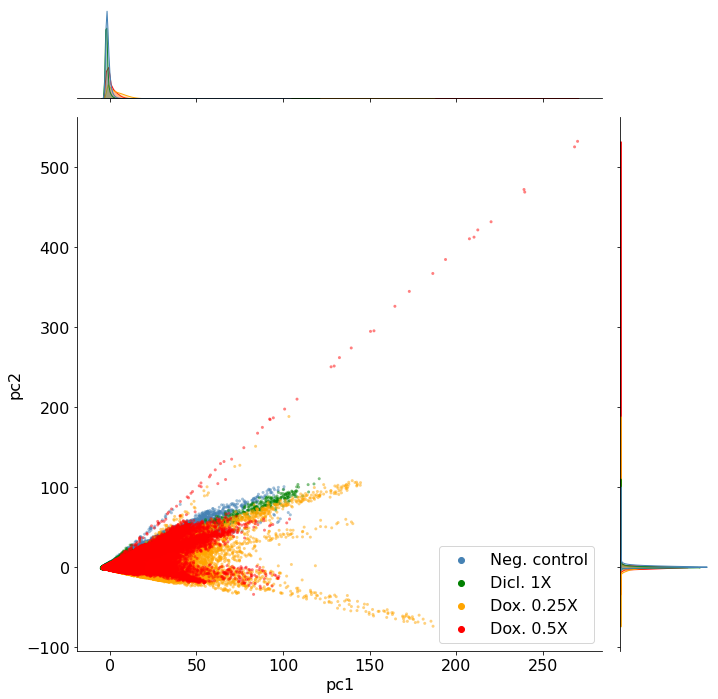

In [20]:
import seaborn as sns
# dfY = pd.DataFrame(Y_std, columns=['pc1','pc2'])
# dfY['class'] = y

plot = sns.jointplot(data=dfY, x="pc1", y="pc2", hue="class", height = 10, alpha=0.5, marker='.', joint_kws={'edgecolor':'none'}, palette={'control':'steelblue','diclo1x':'green','doxo025x':'orange','doxo05x':'red'})
handles,labels = plot.ax_joint.get_legend_handles_labels()
plot.ax_joint.legend(handles, ['Neg. control','Dicl. 1X','Dox. 0.25X','Dox. 0.5X'], loc='lower right')

In [44]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

NameError: name 'Y_sklearn' is not defined

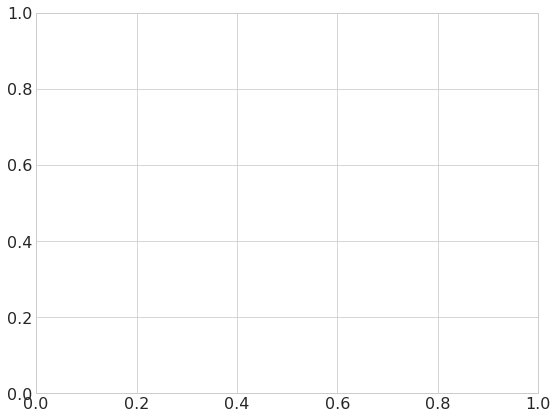

In [21]:
with plt.style.context('seaborn-whitegrid'):
    fig,ax = plt.subplots(figsize=(9,7))
    for lab, col in zip(('control', 'diclo1x', 'doxo025x','doxo05x'),
                        ('steelblue', 'green', 'orange','red')):
        ax.scatter(Y_sklearn[y==lab, 0], Y_sklearn[y==lab, 1], label=lab, c=col, marker=".", alpha=0.3)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    plt.legend(['Neg. Control','Diclo (1X)','Doxo (0.25X)','Doxo (0.5X)'],loc='lower right', fancybox=True, fontsize=13, markerscale=3)
    fig.tight_layout()
    plt.show()

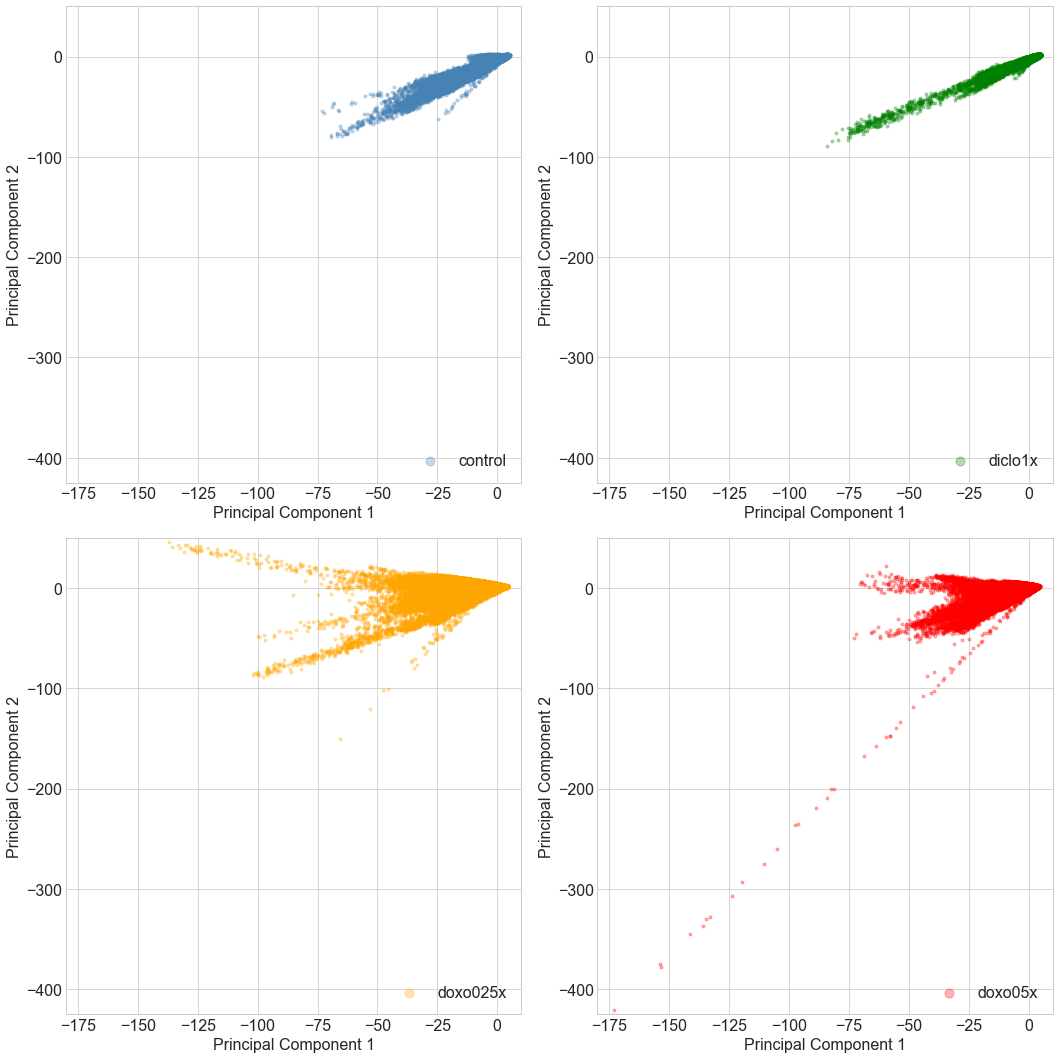

In [26]:
#Y_std = X_std.dot(matrix_w_std)

with plt.style.context('seaborn-whitegrid'): 
    fig = plt.figure(figsize=(15,15))
    for i, lab, col in zip(range(4),('control', 'diclo1x', 'doxo025x', 'doxo05x'),
                        ('steelblue', 'green', 'orange','red')):
        ax = plt.subplot(2,2,i+1)
        ax.scatter(Y_std[y==lab, 0], Y_std[y==lab, 1], label=lab, c=col, marker=".", alpha=0.3)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_xlim(-180,10),ax.set_xticks([-175,-150,-125,-100,-75,-50,-25,0])
        ax.set_ylim(-425,50),ax.set_yticks([-400,-300,-200,-100,0])
        ax.legend(loc='lower right', markerscale=3)
    fig.tight_layout()
    plt.show()

# Test

Generate the arrays:   
a, b, c, d (numbers as elements, number of digits = column no)   
e, f, g, h (letters as elements, number of letters = column no)

Arrays i,j represent small lambda stacks (4 stacked arrays « 4×3×3 » => 4 channel image with 3×3 size)

In [ ]:
import numpy as np
a = np.arange(1,10).reshape(3,3)
b = np.arange(10,19).reshape(3,3)
c = np.arange(100,109).reshape(3,3)
d = np.arange(1000,1009).reshape(3,3)
e = np.array([['a','b','c'],['d','e','f'],['g','h','i']])
f = np.array([['aa','bb','cc'],['dd','ee','ff'],['gg','hh','ii']])
g = np.array([['aaa','bbb','ccc'],['ddd','eee','fff'],['ggg','hhh','iii']])
h = np.array([['aaaa','bbbb','cccc'],['dddd','eeee','ffff'],['gggg','hhhh','iiii']])

i = np.stack((a,b,c,d), axis=0)
j = np.stack((e,f,g,h), axis=0)

k = i.reshape(i.shape[0],(i.shape[1]*i.shape[2])).T
l = j.reshape(j.shape[0],(j.shape[1]*j.shape[2])).T
k,l

In [ ]:
list_i = [k,l,k,l]
classList1 = np.arange(len(list_i),dtype=object)
classList1[0] = 'number'
classList1[2] = 'number'
classList1[1] = 'letter'
classList1[3] = 'letter'
classList2 = []
for i in range(len(list_i)):
    #classArray = np.full((list_i[i].shape[0],1), classList[i])
    classList2 += list_i[i].shape[0] * [classList1[i]]
    #list_i[i] = np.append(list_i[i],classArray,axis=1)
classList2


In [ ]:
import pandas as pd
col = ['1. column','2. column','3. column', '4. column']
df = pd.DataFrame(list_i[0], columns=col)
for j in range(1,len(list_i)):
    currentArr = pd.DataFrame(list_i[j], columns=col)
    df = df.append(currentArr, ignore_index=True)
df['class'] = classList2
df

In [ ]:
#for i in range(len(list_f)):
    
append_i = list_i[0]
for i in range(1,len(list_i)):
    append_i = np.append(append_i,list_i[i],axis=0)
append_i

In [35]:
arr1 = np.arange(1,10).reshape(3,3)
arr2 = np.arange(10,19).reshape(3,3)
arr3 = np.arange(100,109).reshape(3,3)
arr4 = np.arange(1000,1009).reshape(3,3)
arr5 = np.stack((arr1,arr2,arr3,arr4), axis=0)
arr5, arr5.shape, arr5.dtype

(array([[[   1,    2,    3],
         [   4,    5,    6],
         [   7,    8,    9]],
 
        [[  10,   11,   12],
         [  13,   14,   15],
         [  16,   17,   18]],
 
        [[ 100,  101,  102],
         [ 103,  104,  105],
         [ 106,  107,  108]],
 
        [[1000, 1001, 1002],
         [1003, 1004, 1005],
         [1006, 1007, 1008]]]),
 (4, 3, 3),
 dtype('int32'))

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x26a334935e0>)

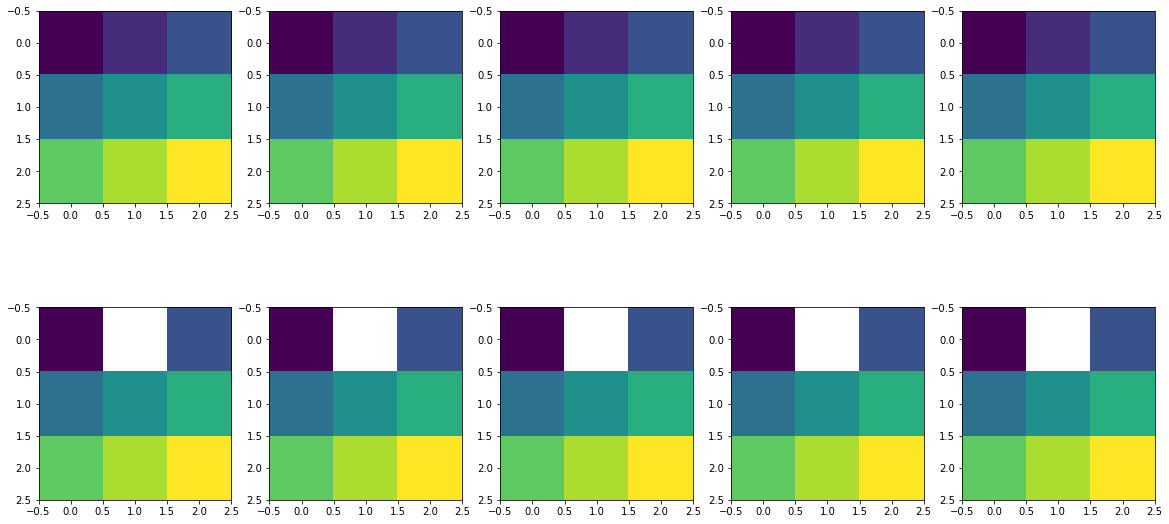

In [36]:
import matplotlib.pyplot as plt
arr5 = np.ma.array(arr5)
sum_arr5 = np.sum(arr5,axis=0)
# sum_arr5.mask = [[0,1,0],[0,0,1],[0,0,0]]
fig = plt.figure(figsize=(20,10))
for j in range(4):
    fig.add_subplot(2,5,j+1)
    plt.imshow(arr5[j], cmap='viridis')
fig.add_subplot(2,5,5), plt.imshow(sum_arr5, cmap='viridis')
arr5.mask = [[0,1,0],[0,0,0],[0,0,0]]
for j in range(4):
    fig.add_subplot(2,5,j+6)
    plt.imshow(arr5[j], cmap='viridis')
sum_arr5 = np.sum(arr5,axis=0)
fig.add_subplot(2,5,10), plt.imshow(sum_arr5, cmap='viridis')

In [30]:
arr5 = np.ma.array(arr5)
arr5.mask = [[0,1,0],[0,0,1],[0,0,0]]
arr5

masked_array(
  data=[[[1, --, 3],
         [4, 5, --],
         [7, 8, 9]],

        [[10, --, 12],
         [13, 14, --],
         [16, 17, 18]],

        [[100, --, 102],
         [103, 104, --],
         [106, 107, 108]],

        [[1000, --, 1002],
         [1003, 1004, --],
         [1006, 1007, 1008]]],
  mask=[[[False,  True, False],
         [False, False,  True],
         [False, False, False]],

        [[False,  True, False],
         [False, False,  True],
         [False, False, False]],

        [[False,  True, False],
         [False, False,  True],
         [False, False, False]],

        [[False,  True, False],
         [False, False,  True],
         [False, False, False]]],
  fill_value=999999)

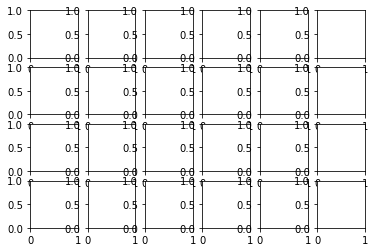

In [63]:
fig, ax = plt.subplots(4,6)

In [64]:
ax

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

# SVD

In [27]:
import numpy as np

U,S,Vt = np.linalg.svd(X_std, full_matrices=False)

print('Shape of X: ', X_std.shape)
print('Shape of U: ', U.shape)
print('Shape of S: ', S.shape)
print('Shape of V^T: ', Vt.shape)
print('Singular values:\n', S)

Shape of X:  (6544642, 33)
Shape of U:  (6544642, 33)
Shape of S:  (33,)
Shape of V^T:  (33, 33)
Singular values:
 [9841.96056208 6803.85554056 3048.0729026  2348.85947167 1980.6990593
 1899.75784509 1828.53670999 1773.3468926  1728.36490756 1671.93533594
 1590.98282234 1565.19186361 1535.59184345 1510.49781133 1483.65500066
 1462.61750111 1439.49862864 1429.83459804 1401.02270555 1397.17529791
 1362.36900966 1291.44191641 1258.85789085 1207.20824468 1176.27374885
 1153.15686398 1116.53403483 1085.69974564 1040.71356732 1004.01528767
  952.68802201  891.85368922  844.91807159]


In [45]:
# We choose the first two columns of U and create a new variable U2 which contains these two principal axes
# U2 = U[:,:2].copy()
# U2 *= -1
U2[:,1] *= -1

# To calculate the coordinates of the data points in the new subspace we multiply the matrices U (here only the first two columns, i.e. using 2 principal axes) and the diagonal matrix of the first 2 diagonal elements of S:
X2 = U2 @ np.diag(S[:2])

Eigenvalues: 
 [14.80053493  7.07333683  1.41959634  0.84300129  0.59944751  0.55145574
  0.5108831   0.48050905  0.45644142  0.42712316  0.38676321  0.37432543
  0.36030125  0.34862166  0.33634116  0.32687048  0.31661879  0.31238184
  0.29991937  0.29827439  0.28359834  0.25483785  0.24214058  0.22267864
  0.21141266  0.20318467  0.19048383  0.18010827  0.16549185  0.15402628
  0.13868056  0.12153501  0.10907956]


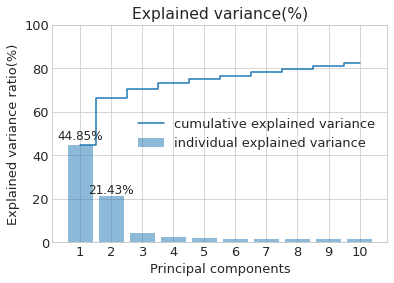

In [46]:
eigvalsSVD = S**2/(X.shape[0]-1)
print('Eigenvalues: \n', eigvalsSVD)

totSVD = sum(eigvalsSVD)
varExpSVD = [(i/totSVD)*100 for i in sorted(eigvalsSVD, reverse=True)]
cumVarExpSVD = np.cumsum(varExpSVD)
plt.rcParams.update({'font.size': 13})

with plt.style.context('seaborn-whitegrid'):
    fig2,ax2 = plt.subplots()
    barPlot = ax2.bar(range(10), varExpSVD[:10], alpha=0.5, align='center', label='individual explained variance')
    ax2.step(range(10), cumVarExpSVD[:10], where='mid', label='cumulative explained variance')
    ax2.set_title('Explained variance(%)')
    ax2.set_ylabel('Explained variance ratio(%)')
    ax2.set_xlabel('Principal components')
    ax2.set_xticks(np.arange(0,10,1)), ax2.set_xticklabels(np.arange(1,11,1))
    ax2.set_ylim(0,100)
    ax2.legend(loc='right', fontsize=13)
    ## Show the values on the bars with variance greater than or equal to 10%:
    labelBar = barPlot.datavalues[barPlot.datavalues>=10]
    for i in range(len(labelBar)):
        ax2.text(ax2.patches[i].get_x()+ax2.patches[i].get_width()/2 ,labelBar[i]*1.05,"{:.2f}%".format(labelBar[i]), ha="center",size=12)
        

In [47]:
dfSVD = pd.DataFrame(X2, columns=['pc1','pc2'])
dfSVD['class'] = y

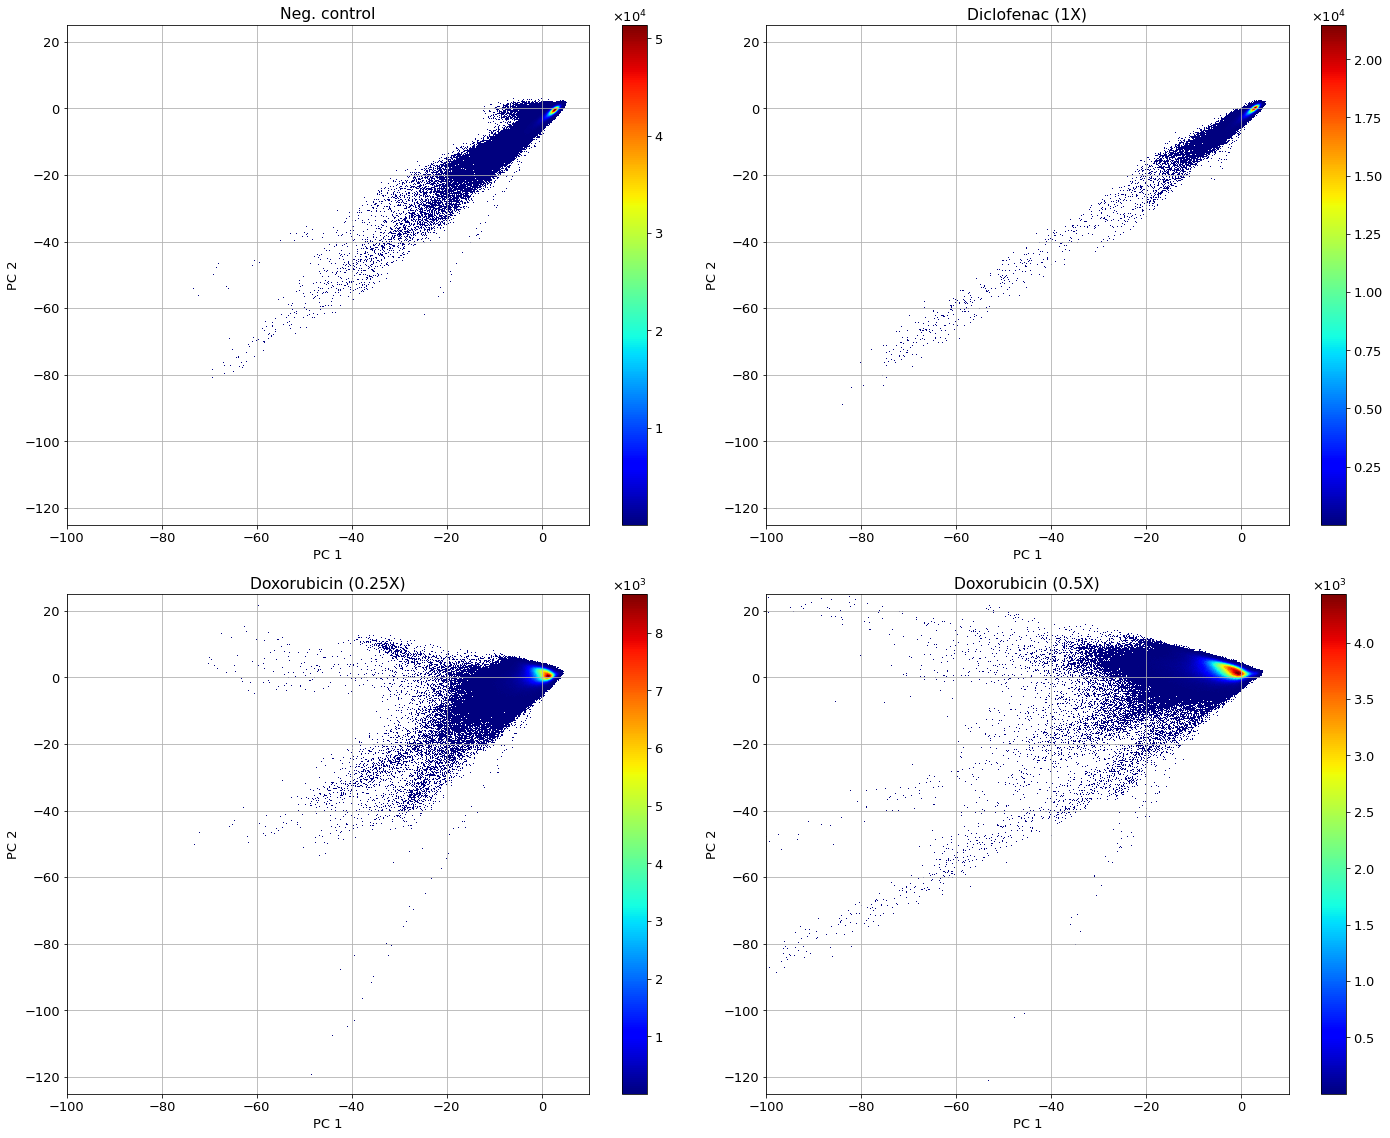

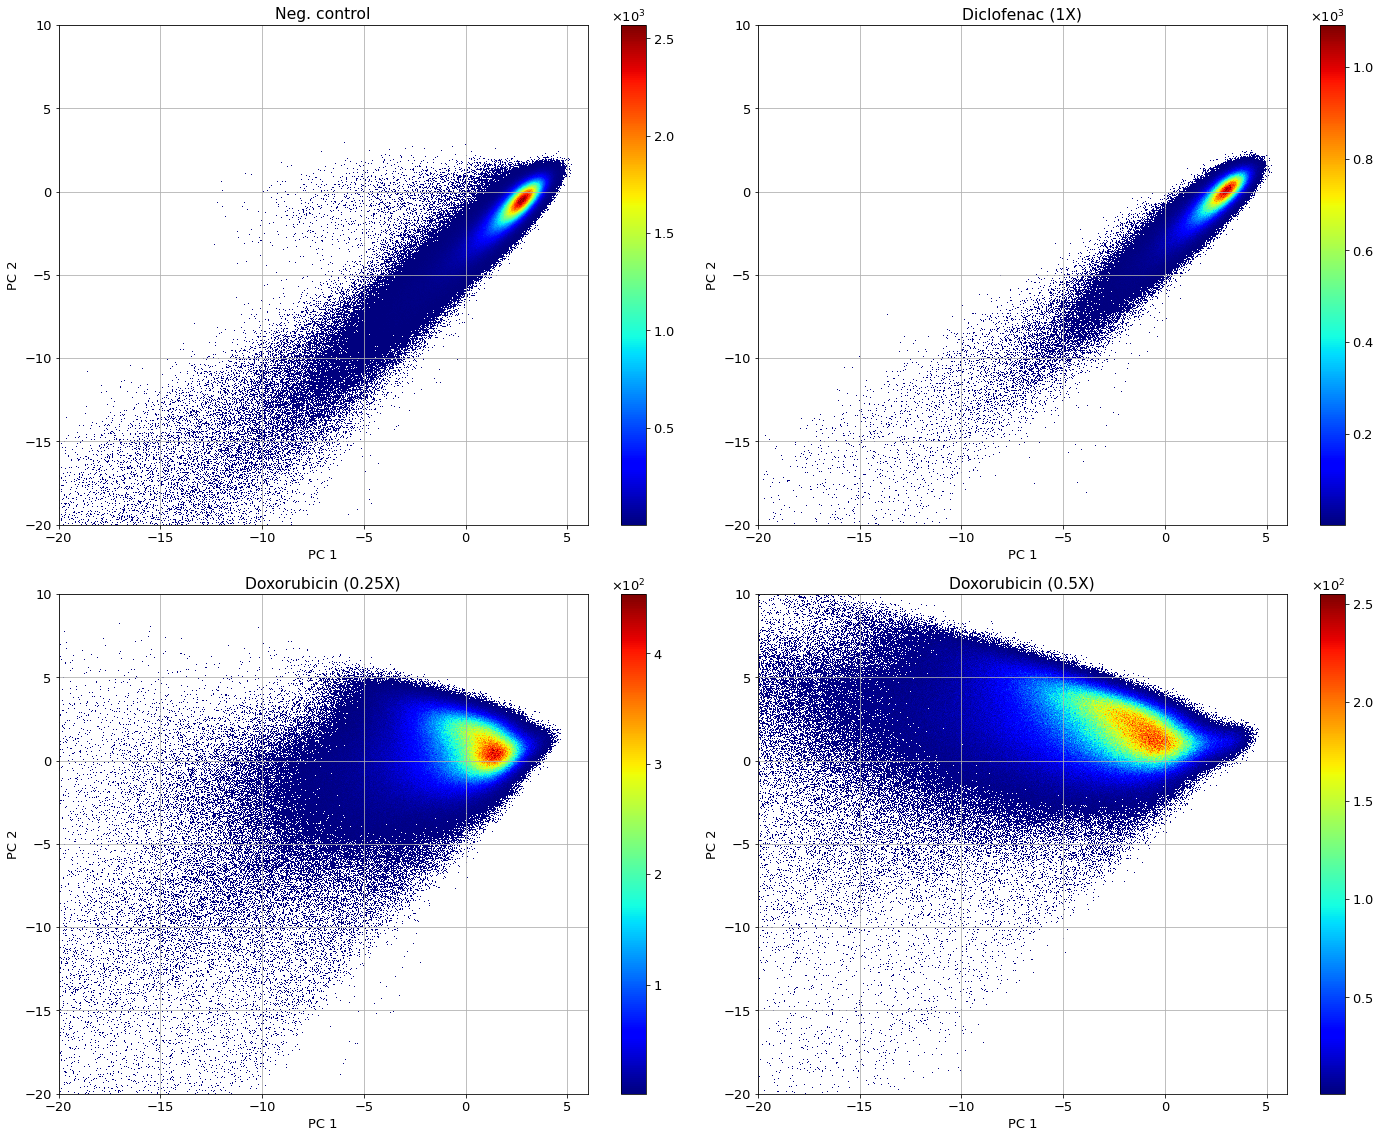

In [48]:
fig3 = plt.figure(figsize=(20,16))
# for i, lab, col in zip(range(4),('control', 'diclo1x', 'doxo025x', 'doxo05x'), ('jet', 'jet', 'jet','jet')):
#     ax = fig.add_subplot(2,2,i+1, projection='scatter_density')
#     densityPlot = ax.scatter_density(Y_std[y==lab,0], Y_std[y==lab,1], cmap='jet', norm=colors.LogNorm())
#     fig.colorbar(densityPlot, ax=ax)

# plt.show()
classDict = dict([('control','Neg. control'),('diclo1x','Diclofenac (1X)'),('doxo025x','Doxorubicin (0.25X)'),('doxo05x','Doxorubicin (0.5X)')])

# yLim = {1:[-150,25],2:[-150,25],3:[-150,50],4:[-450,40]}
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))

for i, lab in zip(range(4),('control', 'diclo1x', 'doxo025x', 'doxo05x')):
    ax11 = fig3.add_subplot(2,2,i+1)
    densityPlot = dsshow(dfSVD[dfSVD["class"]==lab], ds.Point('pc1','pc2'), ds.count(), cmap='jet', aspect='auto', ax=ax11)
    ax11.set_xlim(-100,10), #ax.set_xticks([-175,-150,-125,-100,-75,-50,-25,0])
    ax11.set_ylim(-125,25), #ax.set_yticks([-400,-350,-300,-250,-200,-150,-100,-50,0])
    
    # ax11.set_ylim(-2000,30000)#,ax.set_xticks([-175,-150,-125,-100,-75,-50,-25,0])
    # ax11.set_xlim(-25000,1000)#,ax.set_yticks([-400,-350,-300,-250,-200,-150,-100,-50,0])
    ax11.set_xlabel('PC 1')
    ax11.set_ylabel('PC 2')
    # ax11.set_ylim(yLim[i+1])
    # ax11.set_xlim(-175,10)
    ax11.set_title(classDict[lab])
    ax11.grid(True)
    cbar = fig3.colorbar(densityPlot, format=fmt)
    
    # cbar.formatter.set_powerlimits((-2, 2))
    # cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    
fig3.tight_layout()

plt.show()

fig4 = plt.figure(figsize=(20,16))
for i, lab in zip(range(4), ('control', 'diclo1x', 'doxo025x', 'doxo05x')):
    ax22 = fig4.add_subplot(2,2,i+1)
    densityPlot2 = dsshow(dfSVD[dfSVD["class"]==lab], ds.Point('pc1','pc2'), ds.count(), cmap='jet', aspect='auto', ax=ax22)
    ax22.set_xlim(-20,6)
    ax22.set_ylim(-20,10)
    # ax22.set_xlim(-4000,0)
    # ax22.set_ylim(-500,3000)
    ax22.set_xlabel('PC 1'), ax22.set_ylabel('PC 2')
    ax22.set_title(classDict[lab])
    ax22.grid(True)
    cbar = fig4.colorbar(densityPlot2, format=fmt)
fig4.tight_layout()
plt.show()